In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc,avg, max, min,col,split, regexp_replace,array_join,explode,translate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [12]:
spark = SparkSession.builder.appName("movie-genre").getOrCreate()

df = spark.read.csv("data/movies_clean.csv", header=True, inferSchema=True)

# replace "['Action','Drama']" to "Action,Drama"
df = df.withColumn("Generes", regexp_replace(df["Generes"], "[\[\]']", ""))
df = df.withColumn("Generes", translate(df["Generes"], ", ", ","))

df.show()

+--------------------+------+-----------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+---------------+
|         movie title|Rating|User Rating|             Generes|            Overview|        Plot Kyeword|           Director|         Top 5 Casts|              Writer|           year|
+--------------------+------+-----------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+---------------+
|   Top Gun: Maverick|   8.6|   187000.0|        Action,Drama|After more than t...|['fighter jet', '...|    Joseph Kosinski|['Jack Epps Jr.',...|            Jim Cash|           2022|
|Jurassic World Do...|   6.0|    56000.0|Action,Adventure,...|Four years after ...|['dinosaur', 'jur...|    Colin Trevorrow|['Colin Trevorrow...|    Emily Carmichael|           2022|
|             Top Gun|   6.9|   380000.0|        Action,Drama|As students at th...|['

In [13]:
# explode Generes to a new column Genre
df = df.select(df['movie title'], explode(split(df['Generes'],",")).alias('Genre'))

df = df.groupBy(df['Genre']).count().orderBy('count', ascending=False)

top_genres = df.limit(10).toPandas()
top_genres


,Genre,count
0,Drama,12475
1,Action,7847
2,Comedy,6870
3,Crime,6050
4,Thriller,4974
5,Adventure,4454
6,Horror,3210
7,Romance,3157
8,Sci-Fi,2088
9,Mystery,2078


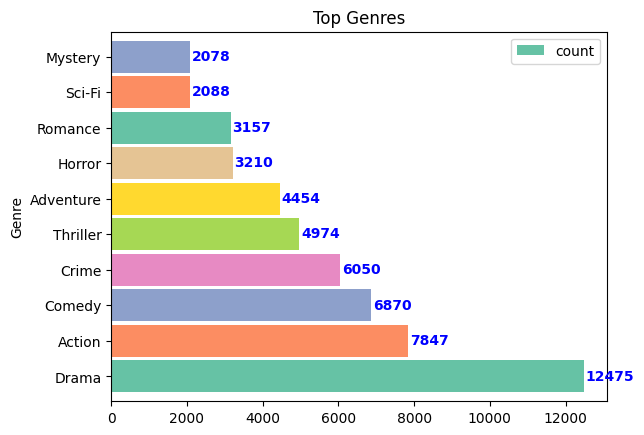

In [21]:
ax = top_genres.plot.barh(x='Genre', y='count',width=0.9, color=plt.cm.Set2(range(7)))

for i, v in enumerate(top_genres['count']):
    ax.text(v + 50, i - 0.1, str(v), color='blue', fontweight='bold')

plt.title('Top Genres')
plt.show()